In [10]:
import numpy as np  
import pandas as pd
import scipy.optimize

import matplotlib.pyplot as plt
import matplotlib.style 
import matplotlib as mpl 

mpl.rcParams['figure.figsize'] = [12.0, 8.0]

Error in intensity is required. However we don't have sufficient data to compute this. So I use Zn 0.025mm's data to calculate an error in measuring the intensity.

In [2]:
zn_film = np.array([509,506,513,501,509,510,501,500,525,510,508,509,495,501,503,489,496,499,499])
mean = np.mean(zn_film)
std = np.std(zn_film)
percentage_error = std/mean

print(percentage_error)

0.015427790140679644


Load data

In [3]:
background_6_16 = pd.read_excel(
    r'C:\Users\David\Desktop\David\third year courses\PHAS0051 Experimental Physics\year 3 X-ray diffraction\background 6-16 1deg.xlsx')

cu_6_16 = pd.read_excel(
    r'C:\Users\David\Desktop\David\third year courses\PHAS0051 Experimental Physics\year 3 X-ray diffraction\cu 6-16 1deg.xlsx')

ni_6_16 = pd.read_excel(
    r'C:\Users\David\Desktop\David\third year courses\PHAS0051 Experimental Physics\year 3 X-ray diffraction\ni 6-16 1deg.xlsx')

sn_6_16 = pd.read_excel(
    r'C:\Users\David\Desktop\David\third year courses\PHAS0051 Experimental Physics\year 3 X-ray diffraction\sn 6-16 1deg.xlsx')

background_16_25 = pd.read_excel(
    r'C:\Users\David\Desktop\David\third year courses\PHAS0051 Experimental Physics\year 3 X-ray diffraction\background 16-25 1 deg.xlsx')

cu_16_25 = pd.read_excel(
    r'C:\Users\David\Desktop\David\third year courses\PHAS0051 Experimental Physics\year 3 X-ray diffraction\cu 16-25 1 deg.xlsx')

ni_16_25 = pd.read_excel(
    r'C:\Users\David\Desktop\David\third year courses\PHAS0051 Experimental Physics\year 3 X-ray diffraction\ni 16-25 1 deg.xlsx')

sn_16_25 = pd.read_excel(
    r'C:\Users\David\Desktop\David\third year courses\PHAS0051 Experimental Physics\year 3 X-ray diffraction\sn 16-25 1deg.xlsx')


Tidy up a bit

In [4]:
def TidyUpData(original_data):
    # constants
    d = 201e-12 # diffraction grating interval
    dead_time = 90e-6
    # drop NaN
    original_data.dropna(axis=0, inplace=True)
    # drop first row, which is unit
    original_data.drop(axis=0,index =[0], inplace=True)
    # drop irrelevant data
    new_data = original_data[['X-ray (ID 01) / Impulse Imp','X-ray (ID 01) / Crystal angle ? _c']]
    # rename column, original name is way too long
    new_data = new_data.rename(columns={"X-ray (ID 01) / Impulse Imp": "impulse", "X-ray (ID 01) / Crystal angle ? _c": "wavelength"})
    # replace count rate with true count rate
    measure_imp = new_data['impulse']
    true_imp = measure_imp/(1-dead_time*measure_imp)
    new_data['impulse'] = true_imp
    # replace angle with wavelength
    angle = new_data['wavelength'].values.astype(float)
    wavelength = 2*d*np.sin(np.deg2rad(angle))
    new_data['wavelength'] = wavelength
    
    # compute uncertainty
    # uncertainty error in wavelength is related to error in angle, which is quite small as the machine is quite accurate
    # so we only consider uncertainty in intensity
    # N = N_0/1-tN_0, delta N approximately = delta N_0, as second term is much smaller.
    # so deltaN/N = deltaN_0/N_0 
    uncertainty = true_imp*percentage_error
    new_data['uncertainty'] = uncertainty
    return new_data


In [5]:
background_6_16 = TidyUpData(background_6_16)
cu_6_16 = TidyUpData(cu_6_16)
ni_6_16 = TidyUpData(ni_6_16)
sn_6_16 = TidyUpData(sn_6_16)
background_16_25 = TidyUpData(background_16_25)
cu_16_25 = TidyUpData(cu_16_25)
ni_16_25 = TidyUpData(ni_16_25)
sn_16_25 = TidyUpData(sn_16_25)

In [6]:
print(cu_6_16)
print(cu_16_25)

    impulse    wavelength uncertainty
2   4.00144  4.202044e-11   0.0617334
3   11.0109  4.899148e-11    0.169874
4   124.377  5.594759e-11     1.91886
5   176.768  6.288665e-11     2.72714
6   186.064  6.980657e-11     2.87056
7   166.457  7.670522e-11     2.56806
8   117.224  8.358050e-11      1.8085
9   81.5948  9.043032e-11     1.25883
10  41.1519  9.725260e-11    0.634882
11  29.0759  1.040453e-10    0.448577
12  22.0436  1.108062e-10    0.340085
    impulse    wavelength uncertainty
2   22.0436  1.108062e-10    0.340085
3   18.0292  1.175334e-10    0.278151
4   16.0231  1.242248e-10    0.247201
5   14.0177  1.308784e-10    0.216262
6   319.956  1.374921e-10     4.93621
7   106.002  1.440639e-10     1.63537
8   254.708  1.505919e-10     3.92958
9    121.31  1.570739e-10     1.87155
10  43.1671  1.635081e-10    0.665972
11  29.0759  1.698925e-10    0.448577


In [14]:
def MuVSZlambdaCube(film_data,background,atomic_number,plot_title):
    thickness = 0.025e-3
    i_i_0 = film_data['impulse'].values.astype(float)/background['impulse'].values.astype(float)
    absorption = -(1/thickness)*np.log(i_i_0)
    # mu = -1/t*ln(I/I_0)
    # error in I/I_0  = sqrt( (error in I / I) ^2 + (error in I_0 / I_0)^2) * I/I_0
    err_I_I0 = np.sqrt(2*percentage_error**2) * i_i_0
    # error in lnx = error in x * 1/x
    # y = ax, delta y =abs(a) * delta x
    absorb_err = np.abs(1/thickness*err_I_I0*(1/i_i_0))
    Z_lambda_cube = atomic_number**3*film_data['wavelength'].values**3
    fig, ax = plt.subplots()  
    
    ax.errorbar(Z_lambda_cube,absorption,yerr=absorb_err,label = 'data')
    ax.set_xlabel("Z^3lambda^3/ m^3")
    ax.set_ylabel("linear absorption coefficient/ m^-1")
    ax.set_title(plot_title)
    ax.legend()

def linear(x,a,b):
    return a*x+b

def MuVSZlambdaCubeWithFit(film_data,background,start,end,atomic_number,plot_title):
    thickness = 0.025e-3
    i_i_0 = film_data['impulse'].values.astype(float)/background['impulse'].values.astype(float)
    absorption = -(1/thickness)*np.log(i_i_0)
    # mu = -1/t*ln(I/I_0)
    # error in I/I_0  = sqrt( (error in I / I) ^2 + (error in I_0 / I_0)^2) * I/I_0
    err_I_I0 = np.sqrt(2*percentage_error**2) * i_i_0
    # error in lnx = error in x * 1/x
    # y = ax, delta y =abs(a) * delta x
    absorb_err = 1/thickness*err_I_I0*(1/i_i_0)
    Z_lambda_cube = atomic_number**3*film_data['wavelength'].values**3
    
    # linear fit
    # only fit value between the absorption edges
    popt,pcov = scipy.optimize.curve_fit(
        linear,Z_lambda_cube[start:end],absorption[start:end],sigma = absorb_err[start:end],p0 = np.array([3e+29,3e+04]))
    
    # plot best fit line
    x = np.linspace(Z_lambda_cube[start]*0.99,Z_lambda_cube[end]*1.001,100)
    y = popt[0]*x + popt[1]
    str1 = 'y = ({a:.2g}+-{da:.1g}) (Z lambda)^3) + ({b:.2g}+-{db:.1g})'
    fig, ax = plt.subplots()  
    ax.plot(x,y,label='linear fit')
    ax.errorbar(Z_lambda_cube,absorption,yerr=absorb_err,fmt = '.',label = 'data')
    ax.set_xlabel("Z^3lambda^3/ m^3")
    ax.set_ylabel("linear absorption coefficient/ m^-1")
    ax.set_title(plot_title)
    ax.legend()
    print(plot_title,"best fit line ignoring absorption edge:")
    print(str1.format(a = popt[0],da = np.sqrt(pcov[0,0]),b=popt[1],db=np.sqrt(pcov[1,1])))
    
    return popt,pcov

Cu film 6-16 degree best fit line ignoring absorption edge:
y = (3.3e+30+-2e+29) (Z lambda)^3) + (9.1e+03+-3e+03)
Ni film 6-16 degree best fit line ignoring absorption edge:
y = (3.9e+30+-2e+29) (Z lambda)^3) + (1.1e+04+-3e+03)
Sn film 6-16 degree best fit line ignoring absorption edge:
y = (4e+29+-1e+28) (Z lambda)^3) + (3.6e+03+-1e+03)


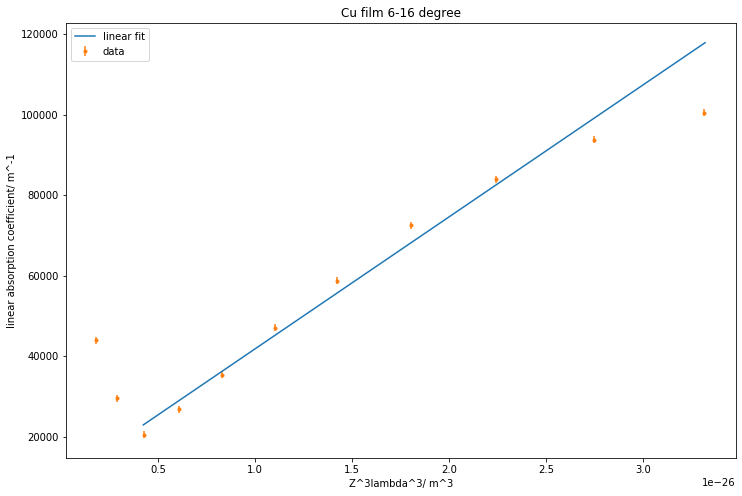

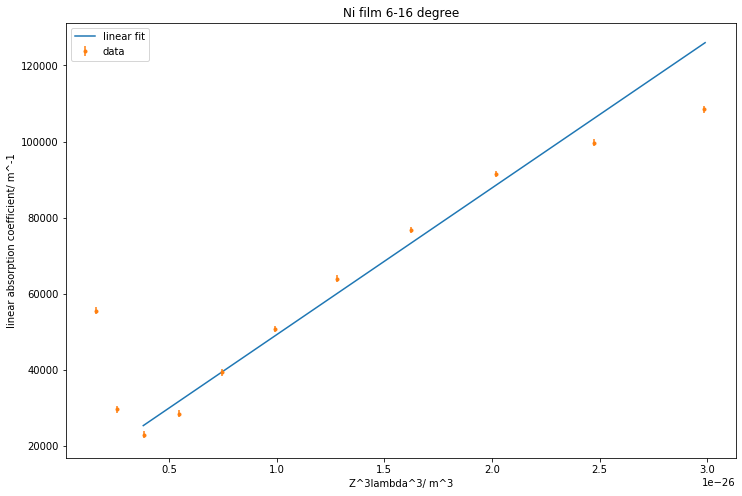

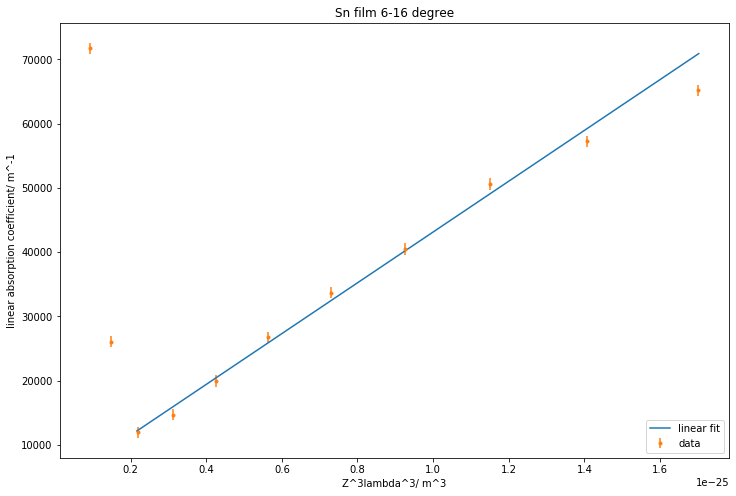

In [11]:
popt,pcov = MuVSZlambdaCubeWithFit(cu_6_16,background_6_16,2,10,29,"Cu film 6-16 degree")
popt2,pcov2 = MuVSZlambdaCubeWithFit(ni_6_16,background_6_16,2,10,28,"Ni film 6-16 degree")
popt3,pcov3 = MuVSZlambdaCubeWithFit(sn_6_16,background_6_16,2,10,50,"Sn film 6-16 degree")


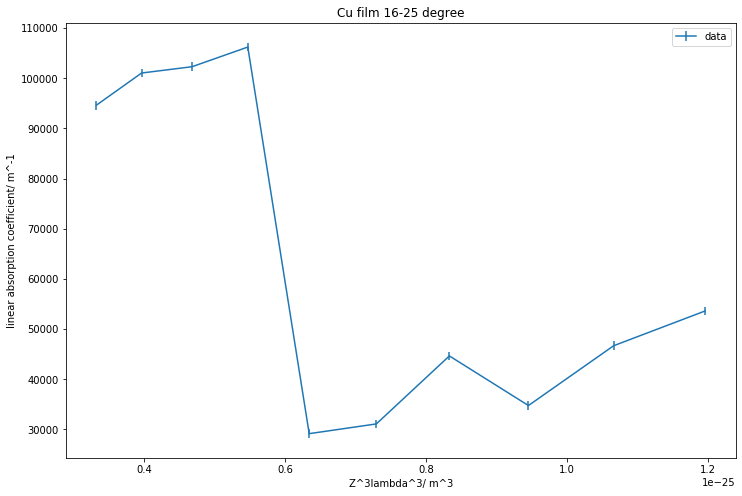

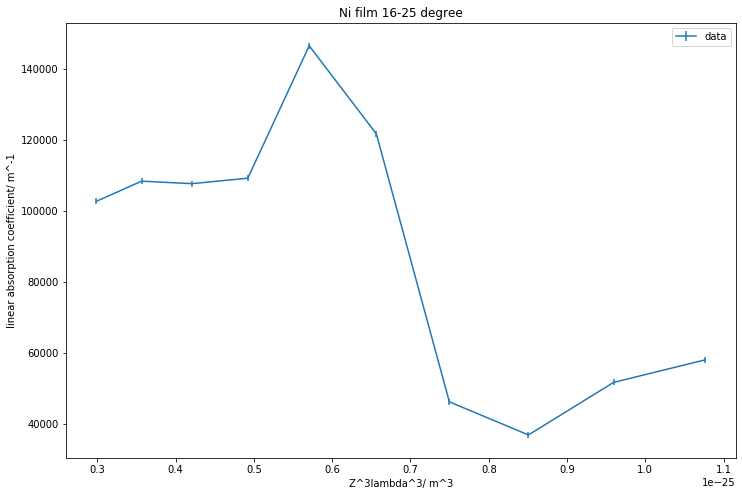

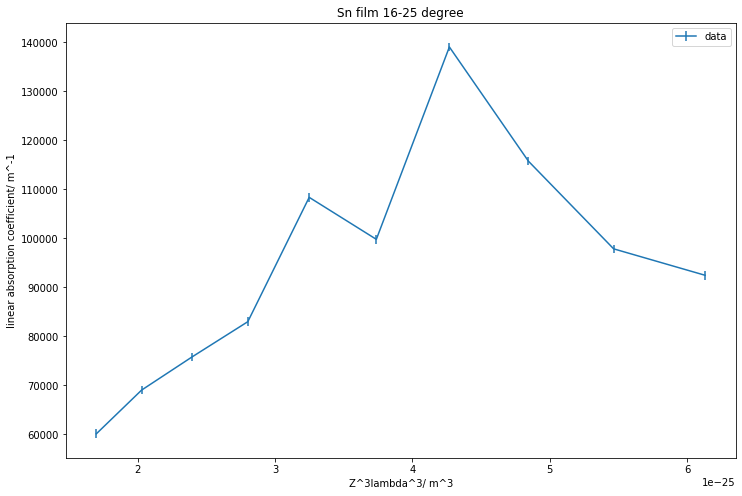

In [15]:

MuVSZlambdaCube(cu_16_25,background_16_25,29,"Cu film 16-25 degree")
MuVSZlambdaCube(ni_16_25,background_16_25,28,"Ni film 16-25 degree")
MuVSZlambdaCube(sn_16_25,background_16_25,50,"Sn film 16-25 degree")